## Homework 4

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [2]:
df = pd.read_csv('data/data.csv')
columns = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = df[columns]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [3]:
y = df.msrp
df = df.drop(['msrp'], axis=1)
above_average = np.mean(y)
y = [int(x > above_average) for x in y]

In [4]:
df_full_train,  df_test, y_full_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- **`engine_hp`**
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [5]:
from sklearn.metrics import roc_curve, auc
columns = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
for column in columns:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[column], pos_label=1)
    area = auc(fpr, tpr)
    if area < 0.5:
        fpr, tpr, thresholds = roc_curve(y_train, -df_train[column], pos_label=1)
        area = auc(fpr, tpr)
    print(f'{column}: {area:.3f}')

year: 0.688
engine_hp: 0.917
engine_cylinders: 0.766
highway_mpg: 0.633
city_mpg: 0.673


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- **0.979**

In [6]:
from sklearn.feature_extraction import DictVectorizer
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
auc(fpr, tpr).round(3)

0.98

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* **0.48**
* 0.68
* 0.88

In [8]:
from collections import Counter
actual_negative = [ 1 if y < 0.50 else 0 for y in y_val]
actual_positive = [ 1 if y >= 0.50 else 0 for y in y_val]
y_pred = model.predict_proba(X_val)
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    
    predict_positive = (y_pred[:,1] >= t)
    predict_negative = (y_pred[:,1] < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [9]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['precision'] = (df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])).round(3)
df_scores['recall'] = (df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])).round(3)

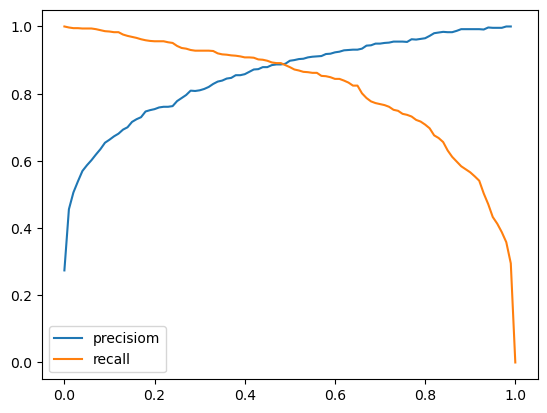

In [10]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precisiom')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- **0.52**
- 0.72

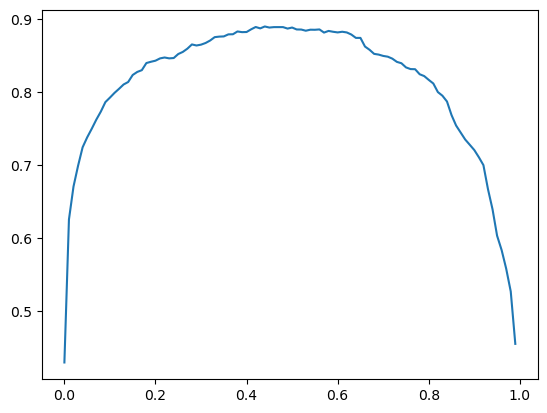

In [11]:
df_scores['F1'] = 2 * (df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')

In [12]:
df_scores.sort_values('F1', ascending=False)

,threshold,tp,fp,fn,tn,precision,recall,F1
44,0.44,589,81,65,1648,0.879,0.901,0.889864
42,0.42,593,87,61,1642,0.872,0.907,0.889156
48,0.48,583,74,71,1655,0.887,0.891,0.888996
47,0.47,583,74,71,1655,0.887,0.891,0.888996
46,0.46,584,76,70,1653,0.885,0.893,0.888982
...,...,...,...,...,...,...,...,...
97,0.97,254,1,400,1728,0.996,0.388,0.558451
98,0.98,234,0,420,1729,1.000,0.358,0.527246
99,0.99,193,0,461,1729,1.000,0.295,0.455598
0,0.00,654,1729,0,0,0.274,1.000,0.430141


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- **0.003**
- 0.030
- 0.090
- 0.140

In [13]:
full_train_dicts = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
scores = []
for train_idx, val_idx in kfold.split(X_full_train):
        df_train = [X_full_train[i] for i in train_idx]
        df_val = [X_full_train[i] for i in val_idx]

        y_train = [y_full_train[i] for i in train_idx]
        y_val = [y_full_train[i] for i in val_idx]

        model.fit(df_train, y_train)
        y_pred = model.predict_proba(df_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
np.std(scores).round(3)

0.002

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- **10**

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [15]:
for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    scores = []
    for train_idx, val_idx in kfold.split(X_full_train):
            df_train = [X_full_train[i] for i in train_idx]
            df_val = [X_full_train[i] for i in val_idx]
    
            y_train = [y_full_train[i] for i in train_idx]
            y_val = [y_full_train[i] for i in val_idx]
    
            model.fit(df_train, y_train)
            y_pred = model.predict_proba(df_val)[:, 1]
    
            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)
    
    print(f'C= {C} {np.mean(scores):.3f} +- {np.std(scores):.3f}')

C= 0.01 0.952 +- 0.002
C= 0.1 0.972 +- 0.001
C= 0.5 0.978 +- 0.003
C= 10 0.983 +- 0.003


## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.